In [22]:
# colab installs
!pip install deep_translator
!wget -O NotoSansSymbols2-Regular.ttf https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf
!pip install ezdxf

--2026-01-14 18:19:17--  https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/notofonts/noto-fonts/raw/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf [following]
--2026-01-14 18:19:17--  https://github.com/notofonts/noto-fonts/raw/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/notofonts/noto-fonts/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf [following]
--2026-01-14 18:19:17--  https://raw.githubusercontent.com/notofonts/noto-fonts/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf
Resolving raw.githubusercontent.com (raw.git

In [85]:
# Imports
%matplotlib inline
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from transformers import CLIPTextModel, CLIPTokenizer, CLIPTextModelWithProjection
from diffusers import AutoencoderKL, UNet2DConditionModel, AutoPipelineForText2Image
from diffusers import LMSDiscreteScheduler
from deep_translator import GoogleTranslator
import re
import cv2
import numpy as np
import ezdxf
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# font_path = "/content/NotoSansSymbols2-Regular.ttf"
font_path = "NotoSansSymbols2-Regular.ttf"

fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Noto Sans Symbols2'

# device to be used
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cuda:0


In [3]:
def hebrew_translator(user_prompt):
    """
    function for testing whether user's input is in Hebrew or in English - if it's
    in Hebrew then it will translate it to English
    :param user_prompt:
    :return:
    """
    contains_hebrew = re.search(r"[\u0590-\u05FF]", user_prompt) is not None
    if contains_hebrew:
        return GoogleTranslator(source='auto', target='en').translate(user_prompt)
    else:
        prompt_en = user_prompt

    return prompt_en

In [4]:
def add_nikud(text):
    """
    מוסיפה סימנים לוגיים (יוניקוד) לפי בחירת המשתמש:
    ב כ פ – דגש
    ו – חולם / שורוק / רגיל
    י – עם חיריק / בלי
    ש – s או sh
    """

    result = ""

    for ch in text:

        # ב כ פ – דגש
        if ch in ('ב', 'כ', 'פ'):
            ans = input(f"האם האות '{ch}' היא עם דגש? (כן/לא) ").strip().lower()
            result += ch
            if ans == 'כן':
                result += DAGESH

        # ו – חולם / שורוק / רגיל
        elif ch == 'ו':
            ans = input(
                "האם זו ו עם חולם vo / שורוק vu / רגיל v? (חו/ש/ר) "
            ).strip().lower()

            result += ch
            if ans == 'חו':
                result += HOLAM
            elif ans == 'ש':
                result += SHURUK

        # י – חיריק
        elif ch == 'י':
            ans = input("האם זו י עם חיריק yi ? (כן/לא) ").strip().lower()
            result += ch
            if ans == 'כן':
                result += HIRIK

        # ש – s או sh
        elif ch == 'ש':
          ans = input("האם זו שׂ (s)? (כן/לא) ").strip().lower()
          result += ch
          if ans == 'כן':
              result += SHIN_DOT

        # שאר האותיות
        else:
            result += ch

    return result


In [5]:
# Braille
DAGESH = '\u05BC'
HIRIK = '\u05B4'
HOLAM = '\u05B9'
SHURUK = '\u05BB'
SHIN_DOT = '\u05C2'

HEBREW_MAP = {
    'א': '⠁',
    'ב': '⠧',
    'ג': '⠛',
    'ד': '⠙',
    'ה': '⠓',
    'ו': '⠺',   # ו רגילה
    'ז': '⠵',
    'ח': '⠭',
    'ט': '⠞',
    'י': '⠚',
    'כ': '⠡',
    'ל': '⠇',
    'מ': '⠍',
    'נ': '⠝',
    'ס': '⠎',
    'ע': '⠫',
    'פ': '⠋', #f
    'צ': '⠮',
    'ק': '⠟',
    'ר': '⠗',
    'ש': '⠩',  #sh
    'ת': '⠹',
    'ך': '⠡',
    'ם': '⠍',
    'ן': '⠝',
    'ף': '⠋',
    'ץ': '⠮',
}

HEBREW_DAGESH_MAP = {
    'ב': '⠃', #B
    'כ': '⠅', #K
    'פ': '⠏', #P
}

VOWEL_TO_BRAILLE = {
    HOLAM: '⠕', # ו עם חולם
    SHURUK: '⠥', # ו עם שורוק
    HIRIK: '⠊',   # י עם חיריק
}

In [6]:
def letter_to_braille(base, marks):

    # שׁ
    if base == 'ש':
      if SHIN_DOT in marks:
        return '⠱'
      return HEBREW_MAP['ש']

    # ב כ פ עם דגש
    if base in HEBREW_DAGESH_MAP and DAGESH in marks:
        return HEBREW_DAGESH_MAP[base]

    # ו
    if base == 'ו':
        if HOLAM in marks:
            return '⠕'
        if SHURUK in marks:
            return '⠥'
        return HEBREW_MAP['ו']

    # י
    if base == 'י':
        if HIRIK in marks:
            return '⠊'
        return HEBREW_MAP['י']

    # רגיל
    return HEBREW_MAP.get(base, base)


In [7]:
def convert_to_braille(text):
    result = []
    i = 0

    while i < len(text):
        ch = text[i]

        if 'א' <= ch <= 'ת':
            base = ch
            marks = []
            i += 1

            # אוספים סימנים לוגיים
            while i < len(text) and '\u0591' <= text[i] <= '\u05C7':
                marks.append(text[i])
                i += 1

            result.append(letter_to_braille(base, marks))
        else:
            result.append(ch)
            i += 1

    return "".join(result)

In [8]:
def convert_tensor_to_pil_img(tensor):
    """
    function converts a tensor of size CxHxW in [-1,1] to a PIL image in [0,255]
    :param x (torch.Tensor): input tensor.
    :return image (PIL.Image): output image.
    """
    image = (tensor / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

In [162]:
def image_to_dxf_exact(image_bw, out_path, canvas_cm=150):
    canvas_mm = canvas_cm * 10.0

    img = image_bw.copy()
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)

    # Ensure white background, black lines
    if np.count_nonzero(img < 128) > np.count_nonzero(img >= 128):
        img = cv2.bitwise_not(img)

    # Extract thin edges ONLY (no morphology)
    edges = cv2.Canny(img, 50, 150)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        edges, connectivity=8
    )

    MIN_AREA = 80   # px — safe for thin lines, removes junk dots

    clean = np.zeros_like(edges)

    for i in range(1, num_labels):  # skip background
        if stats[i, cv2.CC_STAT_AREA] >= MIN_AREA:
            clean[labels == i] = 255

    edges = clean

    contours, _ = cv2.findContours(
        edges,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_NONE
    )

    if not contours:
        raise RuntimeError("No contours found")

    all_pts = np.vstack([c.reshape(-1, 2) for c in contours])
    min_x, min_y = all_pts.min(axis=0)
    max_x, max_y = all_pts.max(axis=0)

    w_px = max_x - min_x + 1
    h_px = max_y - min_y + 1

    scale = canvas_mm / max(w_px, h_px)
    offset_x = (canvas_mm - w_px * scale) / 2
    offset_y = (canvas_mm - h_px * scale) / 2

    def px_to_mm(p):
        x = (p[0] - min_x) * scale + offset_x
        y = (max_y - p[1]) * scale + offset_y
        return (x, y)

    doc = ezdxf.new(setup=True)
    doc.units = ezdxf.units.MM
    msp = doc.modelspace()

    for c in contours:
        pts = [px_to_mm(p[0]) for p in c]
        if len(pts) > 1:
            msp.add_lwpolyline(pts, close=True)

    doc.saveas(out_path)


In [132]:
def png_to_dxf(png_path, dxf_path, canvas_cm=150):
    canvas_mm = canvas_cm * 10.0

    img = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise RuntimeError(f"Could not load {png_path}")

    # binarize
    _, bw = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(
        bw,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE
    )
    if not contours:
        raise RuntimeError("No contours found")

    all_pts = np.vstack([c.reshape(-1,2) for c in contours])
    min_x, min_y = all_pts.min(axis=0)
    max_x, max_y = all_pts.max(axis=0)

    w_px = max_x - min_x + 1
    h_px = max_y - min_y + 1

    scale = canvas_mm / max(w_px, h_px)
    offset_x = (canvas_mm - w_px * scale) / 2
    offset_y = (canvas_mm - h_px * scale) / 2

    def px_to_mm(p):
        x = (p[0] - min_x) * scale + offset_x
        y = (max_y - p[1]) * scale + offset_y
        return (x, y)

    doc = ezdxf.new(setup=True)
    doc.units = ezdxf.units.MM
    msp = doc.modelspace()

    for c in contours:
        pts = [px_to_mm(p[0]) for p in c]
        if len(pts) > 1:
            msp.add_lwpolyline(pts, close=True)

    doc.saveas(dxf_path)

In [10]:
# general settings of Stable Diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    # GPU → float16
    pipe = AutoPipelineForText2Image.from_pretrained(
        "segmind/SSD-1B",
        torch_dtype=torch.float16
    ).to(device)

else:
    # CPU → float32
    pipe = AutoPipelineForText2Image.from_pretrained(
        "segmind/SSD-1B",
        torch_dtype=torch.float32
    ).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.33G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [137]:
## text to image generator from user's input ##

# desired text prompt
hebrew_prompt  = input(" :בבקשה הכנס/י את התמונה שתרצי/שתרצה בספר")
general_prompt = hebrew_translator(hebrew_prompt)
picture_type  = input(" :בבקשה הכנס/י את הקטגוריה של התמונה (פרי, ירק, מספר, אות)")
picture_type = hebrew_translator(picture_type)
user_prompt = (
    f"A single vectorized clean line-art illustration of {general_prompt}, "
    f"classified as a {picture_type}. "
    "Minimalistic outline, high contrast white background, no shading, no texture, "
    "sharp edges, centered composition, no extra objects, no text, no noise."
)

prompt = f"""
simple black and white line art illustration,
children's coloring book style,
clean smooth black outlines,
uniform line thickness,
no fill, no shading,
flat 2D side view,
cartoon but realistic proportions,
minimal details,
white background,
printable coloring page,
clear closed contours

"""

negative_prompt = """
shading, shadows, gradients, grayscale,
sketch, pencil, charcoal,
realistic, photorealistic,
texture, noise, grain,
cross-hatching, dots,
background scenery,
color, paint,
3D, perspective, depth,
thick blobs, uneven lines
"""
# prompt_2 = f"{general_prompt}, classified as a {picture_type}."
# print(prompt_2)
# image = pipe(
#     prompt=prompt,
#     prompt_2=prompt_2,
#     # negative_prompt=negative_prompt,
#     # negative_prompt_2=negative_prompt,
#     width=1024,
#     height=1024,
#     num_inference_steps=25,
#     guidance_scale=7.5,
#     generator=torch.Generator("cuda").manual_seed(42),
#     output_type="pil"
# ).images[0]


user_prompt = [user_prompt]

# # # Generate the image
image = pipe(user_prompt, num_inference_steps=25, guidance_scale=7.5).images[0]

 :בבקשה הכנס/י את התמונה שתרצי/שתרצה בספרדרקון
 :בבקשה הכנס/י את הקטגוריה של התמונה (פרי, ירק, מספר, אות)חיה


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


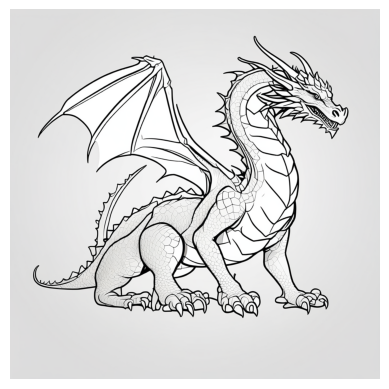

In [138]:
# plot results
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

In [139]:
## Braille converter
hebrew_prompt = add_nikud(hebrew_prompt)
Braille = convert_to_braille(hebrew_prompt)
print(Braille)

האם זו ו עם חולם vo / שורוק vu / רגיל v? (חו/ש/ר) חו
⠙⠗⠟⠕⠝


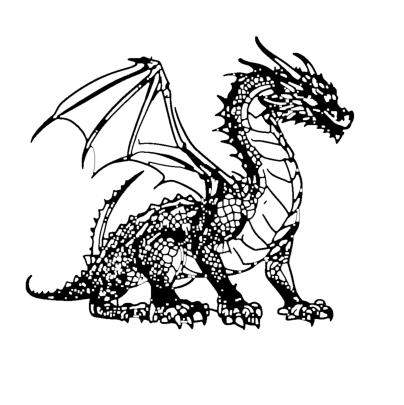

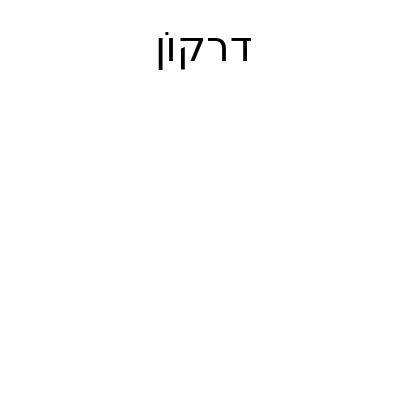

/tmp/ipython-input-1843120861.py:47: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Symbols2.
  plt.savefig("braille.png", dpi=300, bbox_inches="tight", pad_inches=0)
/tmp/ipython-input-1843120861.py:47: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Symbols2.
  plt.savefig("braille.png", dpi=300, bbox_inches="tight", pad_inches=0)


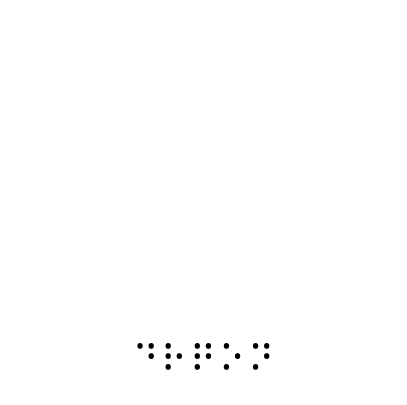

In [140]:
#image processing
image = np.array(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_image, 50, 200)
kernel = np.ones((5, 5), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
edges = cv2.bitwise_not(edges)
h, w = edges.shape
edges[h-1:h, w-1:w] = 255


#centering object
h, w = edges.shape
ys, xs = np.where(edges[1:h-1,1:w-1] == 0)
obj_cx = xs.mean()
obj_cy = ys.mean()
img_cx = w / 2
img_cy = h / 2
shift_x = int(img_cx - obj_cx)
shift_y = int(img_cy - obj_cy)
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
centered = cv2.warpAffine(edges, M, (w, h), borderValue=255)

#plotting final result
# --- 1. Image only ---
plt.figure(figsize=(5,5))
plt.imshow(centered, cmap="gray")
plt.axis("off")
plt.savefig("image_only.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()

# --- 2. Hebrew text only ---
plt.figure(figsize=(5,5))
plt.gca().set_facecolor("white")
plt.text(0.5, 0.9, f'{hebrew_prompt[::-1]}',fontsize=30, color='black', ha='center', va='center', fontweight='light',fontname='DejaVu Sans')
plt.axis("off")
plt.savefig("hebrew.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()

# --- 3. Braille text only ---
plt.figure(figsize=(5,5))
plt.gca().set_facecolor("white")
plt.text(0.5, 0.1, f'{Braille}',fontsize=30, color='black', ha='center', va='center', fontweight='light',fontname='Noto Sans Symbols2')
plt.axis("off")
plt.savefig("braille.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()



In [164]:
# Saving as dxf
image_to_dxf_exact(centered, "image_only.dxf")
png_to_dxf("hebrew.png", "hebrew.dxf")
png_to_dxf("braille.png", "braille.dxf")


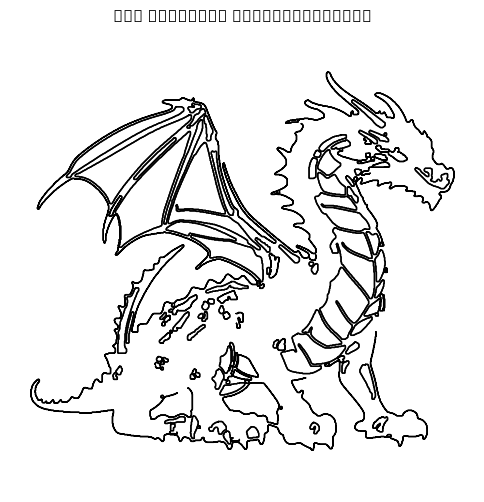

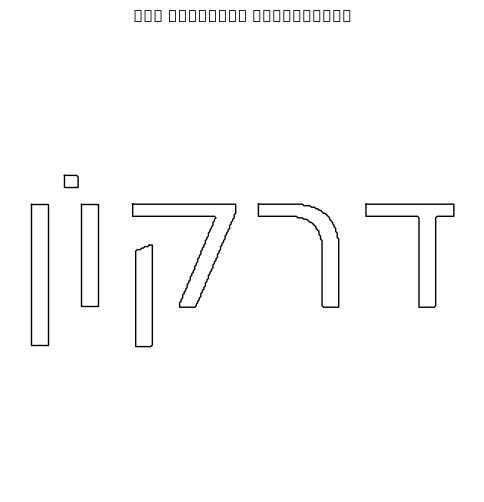

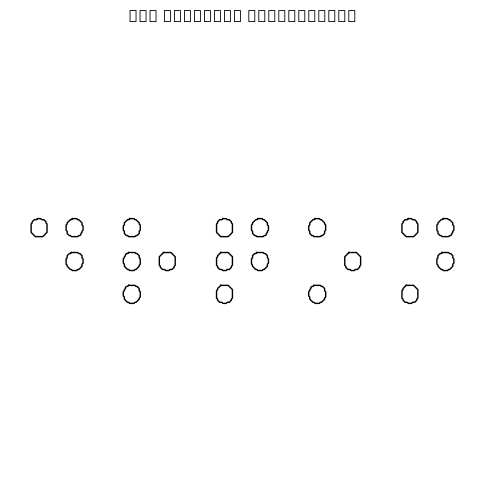

In [165]:
def plot_dxf(dxf_path):
    import ezdxf
    import matplotlib.pyplot as plt
    import numpy as np

    try:
        doc = ezdxf.readfile(dxf_path)
        msp = doc.modelspace()

        plt.figure(figsize=(6, 6))

        for entity in msp:
            if entity.dxftype() == 'LWPOLYLINE':
                points = entity.get_points()
                x = [p[0] for p in points]
                y = [p[1] for p in points]

                if entity.is_closed:
                    x.append(x[0])
                    y.append(y[0])

                plt.plot(x, y, color='black', linewidth=1)

            elif entity.dxftype() == 'CIRCLE':
                center = entity.dxf.center
                radius = entity.dxf.radius

                theta = np.linspace(0, 2*np.pi, 100)
                x = center.x + radius * np.cos(theta)
                y = center.y + radius * np.sin(theta)

                plt.plot(x, y, color='black', linewidth=1)

        plt.axis('equal')
        plt.title(f"DXF Preview: {dxf_path}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Could not plot DXF: {e}")

# Visualize the results
plot_dxf("image_only.dxf")
plot_dxf("hebrew.dxf")
plot_dxf("braille.dxf")